# Hydrological modeling

This notebook explores the hydrological model described in [Leatherbee's erosion blogpost](https://leatherbee.org/index.php/2018/12/10/climate-2-rivers-and-erosion/), itself in turn adapted from Mei-Decaudin-Hu (2007) `10.1109/PF.2007.15`

## Model description

Surface water flows according to the gradient in pressure. Every time point, evaporation causes surface water to decline and precipitation adds to it.

If there is room, surfacewater drains into groundwater and groundwater wells up into surfacewater.

Groundwater flows through sediment and erodable rock according to the gradient in pressure, with a proportionality constant that models rock porosity.

Sediment is picked up and carried according to "sediment capacity" (ie how laden with sediment the water is) and how fast the water is moving.

### Ground

Three types of ground: 
- Bedrock
- Erodable rock
- Sediment
- Vegetation

Erodable rock erodes into sediment at some rate proportional to water velocity and sediment saturation. Bedrock is not erodable (on this model's timescales.) Sediment is picked up and deposited.

Bedrock is always below erodable rock and erodable rock is always below sediment.

### Vegetation, a stretch goal
Vegetation (based on to groundwater and precipitation and sediment) reduces sediment erosion and adds to sediment.


## Mathematical framework

### Functions

Consider the following height functions. Volume is computed by multiplying by an area element $dA$.

- Surfacewater altitude $w_s$
- Groundwater altitude $w_g$
- Sediment altitude $s$ ("soil")
- Erodable rock altitude $r$ ("rock" lol)
  - Rock porosity $p$
- Bedrock altitude $b$ (for "bedrock")
- Dissolved sediment volume $\mu$ (for "$\mu$ud")
  - Solubility capacity $C$

Total heights above reference (sea) level are therefore given by:
- $h_s = w_s + s + r + b$
- $h_g = w_g + b$
the latter as groundwater is coextensive with sediment and erodable rock.

Water pressure $P$ is given by $\rho g h$ where $h$ is height (above some referenec); $g$ is gravitational acceleration; and $\rho$ is the density of water, equal to be $1 kg/L$.

### Constraints

Groundwater is always coextensive with sediment and erodable rock:
$$ w_g \leq s + r $$

### Model

### Surfacewater

Surfacewater moves down the pressure gradient. Thus the rate of change in surfacewater *volume* due to inflow and outflow at a given point is its divergence:
$$ \frac{\partial w_s}{\partial t} = - \Delta P = - \rho g \Delta (w_s + s + r + b) $$
where $\Delta = \nabla\cdot\nabla$ is the Laplace operator, sum of second partial derivatives.

Adding in exchange with groundwater yields:
$$ \frac{\partial w_s}{\partial t} = -\rho g \Delta (w_s + s + r + b) - (\mbox{absorption rate?})\max\{ s + r - w_g, 0 \} + \max\{0, w_g - s + r \}$$

### Groundwater

Similarly, 

$$ \frac{\partial w_g}{\partial t} = - \rho g \Delta (w_g + b) + (\mbox{absorption rate?})\max\{ s + r - w_g, 0 \} - \max\{0, w_g - s + r \}$$

### Sediment absorption

Sediment capacity $C$ is given by $C = k|v|$ where $k$ is a constant, $|v|$ is surfacewater speed:
$$ |v| = |-\nabla P| = \rho g |\nabla (w_s + s + r + b)| $$

Sediment is absorbed or deposited according to the difference between $\mu$ and $Cw_sdA$:
$$ \frac{\partial \mu}{\partial t} = (\mbox{absorption const})(\mu - Cw_sdA) $$

Notice dissolved sediment is a volume - if water volume declines, then all else equal, sediment will precipitate.

If $s > 0$ then 
$$ \frac{\partial s}{\partial t} dA = -\frac{\partial\mu}{\partial t}$$

If $s = 0$ then
$$ \frac{\partial r}{\partial t} dA = -(\mbox{erosion const})\frac{\partial\mu}{\partial t}$$

In [1]:
from dataclasses import dataclass

import triangle as tr
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

In [2]:
def plot_triangulation(ax, B, **kwargs):
    ax.triplot(
        B["vertices"][:, 0],
        B["vertices"][:, 1],
        B["triangles"],
        **kwargs
    )
    ax.scatter(B["vertices"][:, 0],
               B["vertices"][:, 1],
              c="k")
    ax.set_aspect("equal")
    return ax

In [3]:
def plot_function(ax, function, triangulation, **kwargs):
    ax.tricontourf(
        triangulation["vertices"][:, 0],
        triangulation["vertices"][:, 1],
        triangulation["triangles"],
        function,
        **kwargs
    )
    ax.set_aspect("equal")
    return

In [4]:
# https://matplotlib.org/stable/gallery/mplot3d/trisurf3d_2.html

def plot_graph(function, triangulation, **kwargs):
    fig = plt.figure(figsize=plt.figaspect(0.4))

    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.plot_trisurf(
        mtri.Triangulation(
            x=triangulation["vertices"][:,0],
            y=triangulation["vertices"][:,1],
            triangles=triangulation["triangles"]
        ),
        function,
        **kwargs
    )
    plt.show()

## Example to develop against

Let's work in a 50km x 50km region with a triangulation whose triangle areas are roughly 0.5-1 km^2 (so about 2500-5000 locations tracked). Distance units will be km and altitude units will be m.

We'll set some mountain ridges to the north, coastal plain to the south, and introduce a bit of Gaussian noise to make things look cool. To do this as a function of $x$ and $y$ we'll use:
$$ h(x, y) = 10 + \beta(y) \sin(x) \sin(y) + \beta_2(y) \sin( x/2 ) \cos( y/2 )y^2 $$\
where $\beta, \beta_2$ are bump functions.

In [5]:
def beta(y):
    return y**2

In [6]:
def height(x, y):
    height_m = 10\
        + ( 2500 / (1 + np.exp( -0.2 * (y - 25) ) )\
            + np.random.normal( 0, 50 )\
          ) * (1 - 0.2*np.sin(x / 5)**2)
    height_km = height_m / 1000.
    return height_km

In [7]:
example = tr.triangulate({
    "vertices": np.array([[0, 0], [50, 0], [50, 50], [0, 50]])
}, "qa2")

In [8]:
example.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles'])

In [9]:
h = height( example["vertices"][:,0], example["vertices"][:,1] )

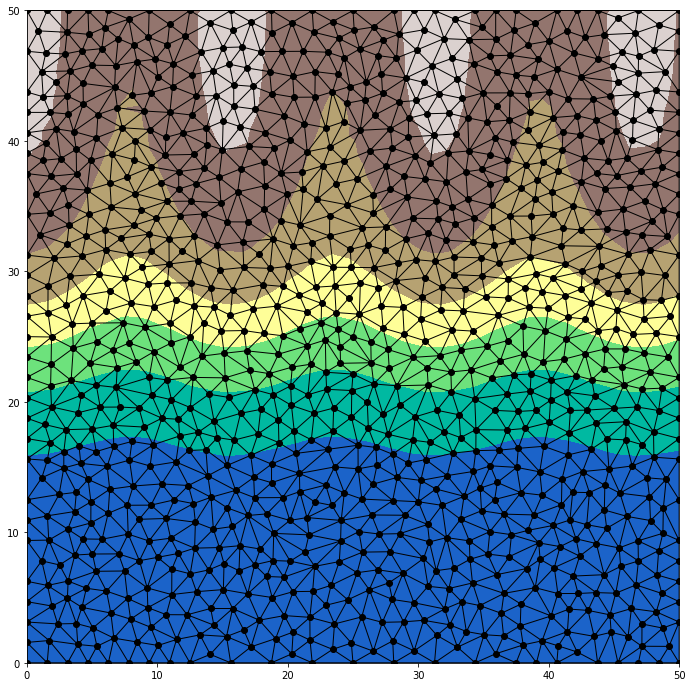

In [10]:
fig, ax = plt.subplots()
plot_function( ax, h, example, cmap="terrain")
plot_triangulation( ax, example, c="k", lw=1 )
fig.set_size_inches(12, 12)
plt.show()

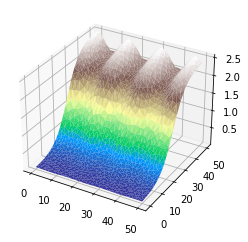

In [11]:
plot_graph(h, example, cmap="terrain")

In [12]:
from scipy import linalg as lin
import itertools
# Finite element laplacian - first order elements
def assemble_matrices( tri ):

    # list the vertices
    v = tri['vertices']
    # list the triangles
    f = tri['triangles']

    # number of vertices
    n = len(v)

    # initialize the matrices for the Laplacian and the inner product 
    # dimensions are (no. vertices)x(no. vertices)
    # Laplacian
    L = np.zeros( (n,n) )

    # L^2 inner product
    M = np.zeros( (n,n) )

    # now loop over each triangle in the mesh and add the submatrix
    # corresponding to the face
    for t in f:
        # set up a dict that remembers which vertex is zeroth, first, second
        d = {t[0]:0,t[1]:1,t[2]:2}

        # vertices of the triangle
        v0 = np.array(v[t[0]])
        v1 = np.array(v[t[1]])
        v2 = np.array(v[t[2]])

        # area of t
        area = np.abs( np.cross(v2-v0, v1-v0) )/2.0

        # barycentric embedding matrix for the triangle
        A = np.array([
            [v0[0], v1[0], v2[0]],
            [v0[1], v1[1], v2[1]],
            [1., 1., 1.]
        ])

        # invert to find the coordinates of the gradients of the
        # elements
        B = lin.inv(A)
        #g = B[:,:2]

        # now iterate through the 9 entries of 
        for i,j in itertools.product(t,t):

            # first, the matrix for the Laplacian
            # (it ends up being the area times the inner product
            # of the two gradients)
            L[i,j] += area*B[d[i],:2].dot(B[d[j],:2])

            # now, the matrix for the L^2 inner product

            # treat the diagonal differently ...
            if i == j:
                M[i,j] += 2.*area / (12.)
            # ... than the off-diagonal
            else:
                M[i,j] += 2.*area / (24.)

    # return the finished product
    return L, M

In [13]:
L, M = assemble_matrices(example)

In [14]:
# First order finite element gradient 


In [15]:
laplacian_of_height = np.dot(L, h)

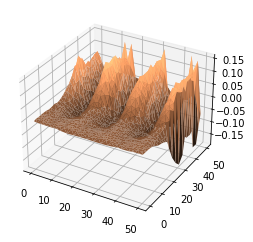

In [16]:
plot_graph(laplacian_of_height, example, cmap="copper")

In [17]:
# core loop

In [26]:
# sediment
sediment = 0.1 * h

# bedrock
bedrock = 0.4 * h * np.sin(example["vertices"][:,0] / 2)**2

# rock
rock = h - sediment - bedrock

# coordinates
x = example["vertices"][:, 0]
y = example["vertices"][:, 1]

# area elements


# water cycle
precipitation = 50 + 0.1 * ( -1 * x + 2 * y ) # m^3/min
evaporation = np.zeros( len(h) ) # 0.01 * (np.max(h) - h) # m^3/min -- more at low altitudes

groundwater = np.zeros( len(h) )
surfacewater = np.zeros( len(h) )

# constants
percolation = 0.1
ZERO = np.zeros(len(h))

# timestep 
dt = 0.01

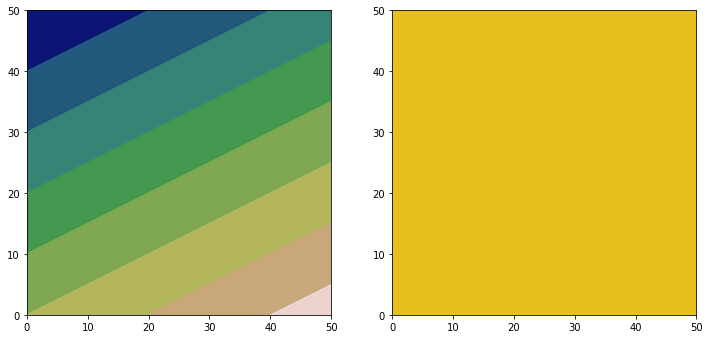

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

plot_function( ax1, -1*precipitation, example, cmap="gist_earth")
plot_function( ax2, evaporation, example, cmap="CMRmap")

fig.set_size_inches(12, 12)
plt.show()

In [28]:
def update():
    # surface/groundwater coupling
    groundwater_to_surface = np.maximum( ZERO , groundwater - rock - sediment ) # excess groundwater transferred to surface
    surfacewater_to_ground = np.minimum( surfacewater, np.maximum( ZERO, rock + sediment - groundwater) )
    
    intermediate_surfacewater = surfacewater + groundwater_to_surface - surfacewater_to_ground
    evap_amount = np.minimum( evaporation, intermediate_surfacewater)
    intermediate_surfacewater = intermediate_surfacewater - evap_amount + precipitation
    
    intermediate_groundwater = groundwater - groundwater_to_surface + surfacewater_to_ground

#     fig,ax = plt.subplots()
#     plot_function(ax, groundwater_to_surface, example)
#     plt.show()
    
#     print(np.max(intermediate_surfacewater))
#     print(np.min(intermediate_surfacewater))
    
#     print(np.max(np.dot(L, intermediate_surfacewater + h)))
#     print(np.min(np.dot(L, intermediate_surfacewater + h)))
    
    new_surfacewater = np.maximum( ZERO, ( intermediate_surfacewater - np.dot(L, intermediate_surfacewater + h) ) * dt )
    new_groundwater = np.maximum( ZERO, ( intermediate_groundwater - percolation * np.dot(L, intermediate_groundwater + bedrock) ) * dt )
    
    

#     # new height
#     new_h = bedrock + rock + sediment
    
    return new_surfacewater, new_groundwater

In [29]:
for _ in range(50000):
    new_surfacewater, new_groundwater = update()
    if np.isnan(np.sum(new_surfacewater)) or np.isnan(np.sum(new_groundwater)):
        raise ValueError
    surfacewater = new_surfacewater
    groundwater = new_groundwater


In [30]:
np.max(surfacewater)

0.5965007147563729

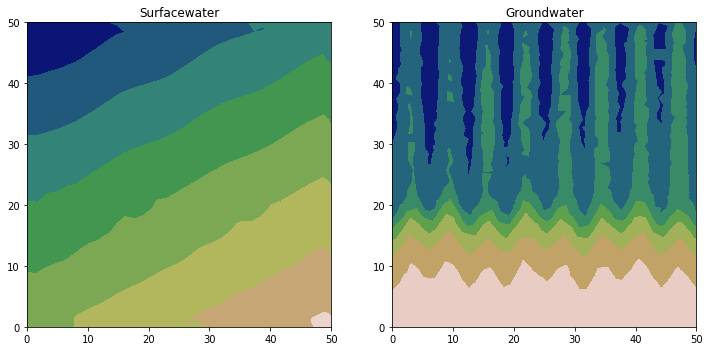

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

plot_function( ax1, -1*surfacewater, example, cmap="gist_earth")
plot_function( ax2, -1*groundwater, example, cmap="gist_earth")

ax1.set_title("Surfacewater")
ax2.set_title("Groundwater")

fig.set_size_inches(12, 12)
plt.show()

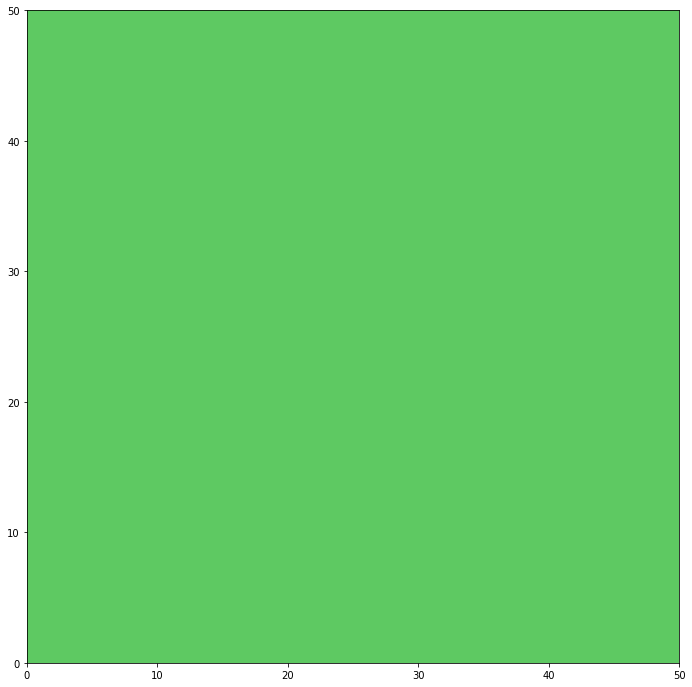

In [32]:
fig, ax = plt.subplots()

plot_function( ax, h, example, cmap="gist_earth", levels=100 )

mask = surfacewater > 1
plot_function( ax, (-1 * surfacewater) * mask, example )

fig.set_size_inches(12, 12)
plt.show()
